In [4]:
!pip install pypdf pandas


     |████████████████████████████████| 12.4 MB 1.3 MB/s eta 0:00:01
  Using cached tzdata-2023.3-py2.py3-none-any.whl (341 kB)
     |████████████████████████████████| 502 kB 131.7 MB/s eta 0:00:01


In [18]:
from pypdf import PdfReader, PdfWriter


def crop_pdf(input_path, output_path, x1, y1, x2, y2):
    with open(input_path, "rb") as file:
        input_pdf = PdfReader(file)
        num_pages = len(input_pdf.pages)

        output_pdf = PdfWriter()

        for page_number in range(num_pages):
            page = input_pdf.pages[page_number]
            page.cropbox.lower_left = (x1, y1)
            page.cropbox.upper_right = (x2, y2)
            output_pdf.add_page(page)

        with open(output_path, "wb") as output_file:
            output_pdf.write(output_file)


crop_pdf("../data/climat-Reykjavik-1-2023.pdf", "../data/output2023.pdf", 25, 178, 375, 770)

In [19]:
# importing required modules
from pypdf import PdfReader
import pandas as pd
import re

# creating a pdf file object

path = "../data/output2023.pdf"
pdf_file = open(path, "rb")

# creating a pdf reader object
reader = PdfReader(pdf_file)

# creating a page object
page = reader.pages[0]  # Access the first page

table_content = page.extract_text(0, 90)
table_content = table_content.split("\n")

table_content = table_content[:-27]
table_content = [x.strip() for x in table_content]


amount_of_columns = 12
amount_of_rows = 31
index_of_end_of_table = []
for i in range(amount_of_columns):
    index = amount_of_rows - i + (amount_of_rows * i)
    index_of_end_of_table.append(index)


data = []

print(index_of_end_of_table)

for i, split_index in enumerate(index_of_end_of_table):
    if i == 0:
        data.append(table_content[:split_index])
    else:
        data.append(table_content[index_of_end_of_table[i - 1] : split_index])


# fix last cell in each row
for i, row in enumerate(data):
    last_cell = row[-1]

    if "−" in last_cell:
        last_cell = last_cell.replace("−", " -")
        last_cell = last_cell.split(" ")
        last_cell = [x for x in last_cell if x != ""]

        row[-1] = last_cell[0]

        if i + 1 < len(data):
            data[i + 1].insert(0, last_cell[1])

    if " " in last_cell:
        last_cell = last_cell.split(" ")

        row[-1] = last_cell[0]

        if i + 1 < len(data):
            data[i + 1].insert(0, last_cell[1])

    if "." in last_cell and len(last_cell) > 4:
        # Match the last decimal place and add a space after it
        modified_string = re.sub(r"(\.\d+)(?!\.)", r"\1 ", last_cell)
        modified_string = modified_string.split(" ")
        modified_string = [x for x in modified_string if x != ""]

        row[-1] = modified_string[0]

        if i + 1 < len(data):
            data[i + 1].insert(0, modified_string[1])

    # if last cell does not match amount of decimals
    if "." in last_cell and len(last_cell.split(".")[-1]) > 1:
        # split after last decimal place
        modified_string = last_cell.split(".")
        modified_string = modified_string[0] + "." + modified_string[1][0]

        new_cell = last_cell.replace(modified_string, "")

        row[-1] = modified_string

        if i + 1 < len(data):
            data[i + 1].insert(0, new_cell)



    # if rain type column
    if (
        i == 5
        and last_cell != ""
        and last_cell != "sn"
        and last_cell != "sl"
        and last_cell != "ri"
    ):
        row[-1] = ""

        if i + 1 < len(data):
            data[i + 1].insert(0, last_cell)

    # if snow type column has too large value
    if i == 6 and len(last_cell) > 2:
        corrected_value = last_cell[:2]
        row[-1] = corrected_value

        if i + 1 < len(data):
            data[i + 1].insert(0, last_cell[2:])

    # if range of snow cover column has too large value
    if i == 7 and len(last_cell) > 1:
        corrected_value = last_cell[:1]
        row[-1] = corrected_value

        if i + 1 < len(data):
            data[i + 1].insert(0, last_cell[1:])

    print(i, len(row), row)


header = [
    "day",
    "avg temperature",
    "max temp",
    "min temp",
    "rain",
    "rain type",
    "snow depth",
    "snow type",
    "sun hours",
    "avg wind",
    "max wind",
    "gust",
]

# rotate data
data = list(map(list, zip(*data)))

df = pd.DataFrame(data, columns=header)
# print(data)

csv_path = path.split("/")[-1].replace(".pdf", ".csv")
df.to_csv("../data/climat/" + csv_path, index=False)

[31, 61, 91, 121, 151, 181, 211, 241, 271, 301, 331, 361]
0 31 ['1', '2', '3', '4', '5', '6', '7', '8', '9', '10', '11', '12', '13', '14', '15', '16', '17', '18', '19', '20', '21', '22', '23', '24', '25', '26', '27', '28', '29', '30', '31']
1 31 ['-5,2', '1,3', '−2,4', '−5,9', '−7,8', '−4,5', '−1,9', '1,3', '−0,6', '1,4', '−2,3', '−1,3', '−2,5', '−7,0', '−10,1', '−6,5', '−4,3', '−10,2', '−5,7', '4,7', '2,0', '−0,9', '−1,7', '3,9', '1,3', '5,7', '1,8', '3,3', '−0,1', '−1,6', '-0,8']
2 31 ['-2,7', '3,0', '2,1', '−1,0', '−5,7', '−0,9', '−0,3', '3,0', '1,8', '3,5', '4,0', '0,4', '0,5', '−2,6', '−7,5', '−2,7', '−0,8', '−5,7', '−4,2', '6,8', '6,8', '2,6', '1,0', '5,9', '3,7', '7,9', '5,4', '6,6', '3,8', '0,5', '2,9']
3 31 ['-10,9', '−6,9', '−4,0', '−7,0', '−9,9', '−10,4', '−5,4', '−2,9', '−1,6', '−3,9', '−3,5', '−5,1', '−3,8', '−9,3', '−11,3', '−12,2', '−6,4', '−12,1', '−12,3', '−4,5', '0,5', '−5,0', '−5,0', '−1,8', '−1,2', '1,6', '−1,0', '0,8', '−0,6', '−5,2', '-1,3']
4 31 ['5,7', '4,1', '5

In [2]:
import pandas as pd


In [15]:
weather = pd.read_csv(
    "../data/weather_data_reykjavik.csv", sep="\t", skiprows=1
)  # Reykjavik weather data
pool = pd.read_csv("../data/heimsoknir_i_sundlaugar_heild.csv")

# rename columns
pool = pool.rename(
    columns={
        "dagsetning": "date",
        "timi_dags": "time_of_day",
        "sundlaug": "pool",
        "fjoldi_gesta": "visitors",
        "ar": "year",
        "manudur": "month",
        "vikudagur": "weekday",
        "arstid": "season",
        "helgi": "weekend",
    }
)


# weather =weather.rename(columns={'Ár': 'year', 'Mánuður':'month', 'Meðalhiti (°C)': 'monthly_average_temp',	'Meðalhámarkshiti (°C)': 'monthly_max_temp',	'Meðallágmarkshiti (°C)': 'monthly_min_temp',	'Úrkoma (mm)':'monthly_rain', 'Meðalvindhraði (m/s)': 'monthly_average_windspeed',	'Sólskinsstundir (klst)':'monthly_hours_sunshine'})

# months = ['Janúar', 'Febrúar', 'Mars', 'Apríl', 'Maí', 'Júní', 'Júlí', 'Ágúst', 'September', 'Október', 'Nóvember', 'Desember']

# weather = weather[weather['month'] != 'Ársmeðaltal']
# weather['month'] = weather['month'].apply(lambda x: months.index(x)+1).astype(int)

# date = pd.to_datetime(weather[['year', 'month']].assign(DAY=1))
# weather['year'] = date.dt.year

# # make sure all columns are numeric
# weather = weather.apply(pd.to_numeric, errors='ignore')

# weather["monthly_average_temp"] = weather["monthly_average_temp"].str.replace(",", ".").astype(float)
# weather["monthly_max_temp"] = weather["monthly_max_temp"].str.replace(",", ".").astype(float)
# weather["monthly_min_temp"] = weather["monthly_min_temp"].str.replace(",", ".").astype(float)
# weather["monthly_rain"] = weather["monthly_rain"].str.replace(",", ".").astype(float)
# weather["monthly_average_windspeed"] = weather["monthly_average_windspeed"].str.replace(",", ".").astype(float)
# weather["monthly_hours_sunshine"] = weather["monthly_hours_sunshine"].str.replace(",", ".").astype(float)


weather

,stöð,ár,mán,t,tx,txx,txxD1,tn,tnn,tnnD1,rh,r,rx,rxD1,p,n,sun,f
0,1,1949,1,-2.7,0.5,6.6,9,-6.8,-15.2,12,81.0,68.8,9.6,25,996.7,6.0,18.1,8.5
1,1,1949,2,0.0,2.5,7.8,6,-2.5,-7.5,27,87.0,80.0,8.3,16,989.0,6.7,25.1,9.2
2,1,1949,3,0.1,2.8,7.4,4,-2.9,-14.3,14,86.0,58.7,8.4,5,1010.4,5.9,106.6,5.9
3,1,1949,4,-0.0,3.1,6.6,2,-2.9,-8.9,21,77.0,51.8,17.8,18,1000.2,5.8,134.7,7.4
4,1,1949,5,3.6,7.2,13.0,22,0.3,-5.0,5,70.0,27.9,5.5,12,1014.8,5.1,243.2,6.9
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
888,1,2023,1,-1.8,1.2,7.9,26,-5.2,-12.3,19,74.0,74.2,15.9,21,998.9,5.0,46.8,4.0
889,1,2023,2,2.1,4.6,9.2,13,-0.5,-6.2,9,80.0,141.3,25.9,3,1000.6,6.8,35.9,6.2
890,1,2023,3,-1.6,1.9,8.7,31,-4.3,-14.8,11,59.0,5.0,3.0,31,1013.5,4.5,207.5,3.6
891,1,2023,4,5.2,8.8,12.0,19,2.8,-2.8,29,74.0,87.0,14.3,10,1012.5,6.2,170.4,4.0


In [4]:
# add column "date time"
time_span = pool["time_of_day"]  # e.g. 12-13
time_of_day = time_span.map(lambda x: x.split("-")[1])  # e.g. 13
time_of_day = time_of_day.map(
    lambda x: x + ":00" if len(x) == 2 else "0" + x + ":00"
)  # e.g. 13:00
time_of_day = time_of_day.map(
    lambda x: "00:00" if x == "24:00" else x
)  # 24:00 -> 00:00

date = pool["date"]  # e.g. 2019-01-02
date = date.map(lambda x: x.split("-"))  # e.g. ['2019', '01', '02']
date = date.map(lambda x: x[2] + "-" + x[1] + "-" + x[0])  # e.g. 02-01-2019

pool["date_time"] = date + " " + time_of_day
pool["date_time"] = pd.to_datetime(pool["date_time"], format="%d-%m-%Y %H:%M")

pool["unix_time"] = pool["date_time"].map(lambda x: x.timestamp())

pool["weekend"] = pool["date_time"].map(lambda x: x.weekday() >= 5).astype(bool)
pool["weekday"] = pool["date_time"].map(lambda x: x.weekday()).astype(int)
pool["month"] = pool["date_time"].map(lambda x: x.month).astype(int)
pool["year"] = pool["date_time"].map(lambda x: x.year).astype(int)
pool["season"] = pool["date_time"].map(
    lambda x: x.month % 12 // 3 + 1
)  # 1: winter, 2: spring, 3: summer, 4: fall

pool["hour"] = pool["date_time"].map(lambda x: x.hour).astype(int)

pool = pool.drop(columns=["date", "time_of_day"])

pool

,pool,visitors,year,season,month,weekday,weekend,date_time,unix_time,hour
0,Grafarvogslaug,6,2019,3,8,0,False,2019-08-26 20:00:00,1.566850e+09,20
1,Grafarvogslaug,1,2019,3,8,0,False,2019-08-26 21:00:00,1.566853e+09,21
2,Árbæjarlaug,10,2019,3,8,1,False,2019-08-27 09:00:00,1.566896e+09,9
3,Árbæjarlaug,34,2019,3,8,1,False,2019-08-27 10:00:00,1.566900e+09,10
4,Árbæjarlaug,21,2019,3,8,1,False,2019-08-27 11:00:00,1.566904e+09,11
...,...,...,...,...,...,...,...,...,...,...
131389,Sundhöll Reykjavíkur,109,2023,3,6,0,False,2023-06-12 18:00:00,1.686593e+09,18
131390,Sundhöll Reykjavíkur,75,2023,3,6,0,False,2023-06-12 19:00:00,1.686596e+09,19
131391,Sundhöll Reykjavíkur,106,2023,3,6,0,False,2023-06-12 20:00:00,1.686600e+09,20
131392,Sundhöll Reykjavíkur,141,2023,3,6,0,False,2023-06-12 21:00:00,1.686604e+09,21


In [5]:
# merge dataframes
weather["month"] = weather["month"].astype(int)
weather["year"] = weather["year"].astype(int)
pool["month"] = pool["month"].astype(int)
pool["year"] = pool["year"].astype(int)


df = pd.merge(pool, weather, on=["year", "month"])
df = df.drop(columns=["year", "month", "_id"])

df

,pool,visitors,season,weekday,weekend,date_time,unix_time,hour,monthly_average_temp,monthly_max_temp,monthly_min_temp,monthly_rain,monthly_average_windspeed,monthly_hours_sunshine


In [6]:
# Grafarvogslaug
grafarvogslaug = pool[pool["pool"] == "Grafarvogslaug"]

# Árbæjarlaug
arbaejarlaug = pool[pool["pool"] == "Árbæjarlaug"]

# Breiðholtslaug
breidholtslaug = pool[pool["pool"] == "Breiðholtslaug"]

# Sundhöll Reykjavíkur
sundholl_reykjavikur = pool[pool["pool"] == "Sundhöll Reykjavíkur"]

# Vesturbæjarlaug
vesturbaejarlaug = pool[pool["pool"] == "Vesturbæjarlaug"]

# Laugardalslaug
laugardalslaug = pool[pool["pool"] == "Laugardalslaug"]

In [6]:
laugardalslaug


,pool,visitors,year,season,month,weekday,weekend,date_time,unix_time,hour
245,Laugardalslaug,1,2019,3,8,4,False,2019-08-30 12:00:00,1.567166e+09,12
246,Laugardalslaug,1,2019,3,8,4,False,2019-08-30 14:00:00,1.567174e+09,14
247,Laugardalslaug,1,2019,3,8,4,False,2019-08-30 15:00:00,1.567177e+09,15
248,Laugardalslaug,8,2019,3,8,4,False,2019-08-30 17:00:00,1.567184e+09,17
249,Laugardalslaug,16,2019,3,8,4,False,2019-08-30 18:00:00,1.567188e+09,18
...,...,...,...,...,...,...,...,...,...,...
131373,Laugardalslaug,119,2023,3,6,0,False,2023-06-12 19:00:00,1.686596e+09,19
131374,Laugardalslaug,104,2023,3,6,0,False,2023-06-12 20:00:00,1.686600e+09,20
131375,Laugardalslaug,181,2023,3,6,0,False,2023-06-12 21:00:00,1.686604e+09,21
131376,Laugardalslaug,60,2023,3,6,0,False,2023-06-12 22:00:00,1.686607e+09,22


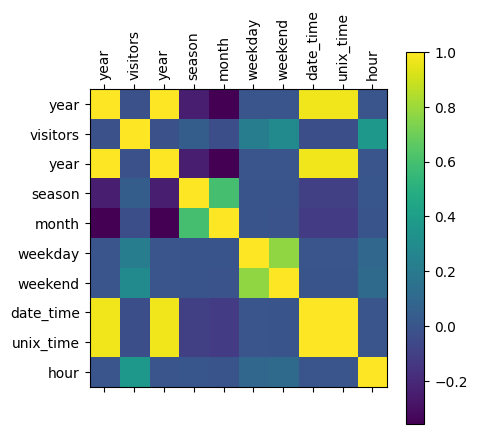

,year,visitors,year,season,month,weekday,weekend,date_time,unix_time,hour
year,1.000000,-0.022661,1.000000,-0.246169,-0.357995,0.000848,-0.000161,0.968456,0.968456,-0.000932
visitors,-0.022661,1.000000,-0.022661,0.045090,-0.030921,0.213571,0.290324,-0.031823,-0.031823,0.363596
year,1.000000,-0.022661,1.000000,-0.246169,-0.357995,0.000848,-0.000161,0.968456,0.968456,-0.000932
season,-0.246169,0.045090,-0.246169,1.000000,0.600545,-0.003023,-0.005921,-0.102557,-0.102557,0.007365
month,-0.357995,-0.030921,-0.357995,0.600545,1.000000,-0.005517,-0.010779,-0.114920,-0.114920,-0.006426
weekday,0.000848,0.213571,0.000848,-0.003023,-0.005517,1.000000,0.776750,-0.000560,-0.000560,0.089293
weekend,-0.000161,0.290324,-0.000161,-0.005921,-0.010779,0.776750,1.000000,-0.003030,-0.003030,0.113238
date_time,0.968456,-0.031823,0.968456,-0.102557,-0.114920,-0.000560,-0.003030,1.000000,1.000000,-0.002361
unix_time,0.968456,-0.031823,0.968456,-0.102557,-0.114920,-0.000560,-0.003030,1.000000,1.000000,-0.002361
hour,-0.000932,0.363596,-0.000932,0.007365,-0.006426,0.089293,0.113238,-0.002361,-0.002361,1.000000


In [7]:
# correlation matrix
import matplotlib.pyplot as plt

# grafarvogslaug
_grafarvogslaug = grafarvogslaug[
    [
        "year",
        "visitors",
        "year",
        "season",
        "month",
        "weekday",
        "weekend",
        "date_time",
        "unix_time",
        "hour",
    ]
]
grafarvogslaug_corr = _grafarvogslaug.corr()


# Plot correlation matrix
plt.matshow(grafarvogslaug_corr)
plt.colorbar()
# Add labels to the plot
plt.xticks(
    range(len(grafarvogslaug_corr.columns)),
    grafarvogslaug_corr.columns,
    rotation="vertical",
)
plt.yticks(range(len(grafarvogslaug_corr.columns)), grafarvogslaug_corr.columns)
plt.show()

grafarvogslaug_corr

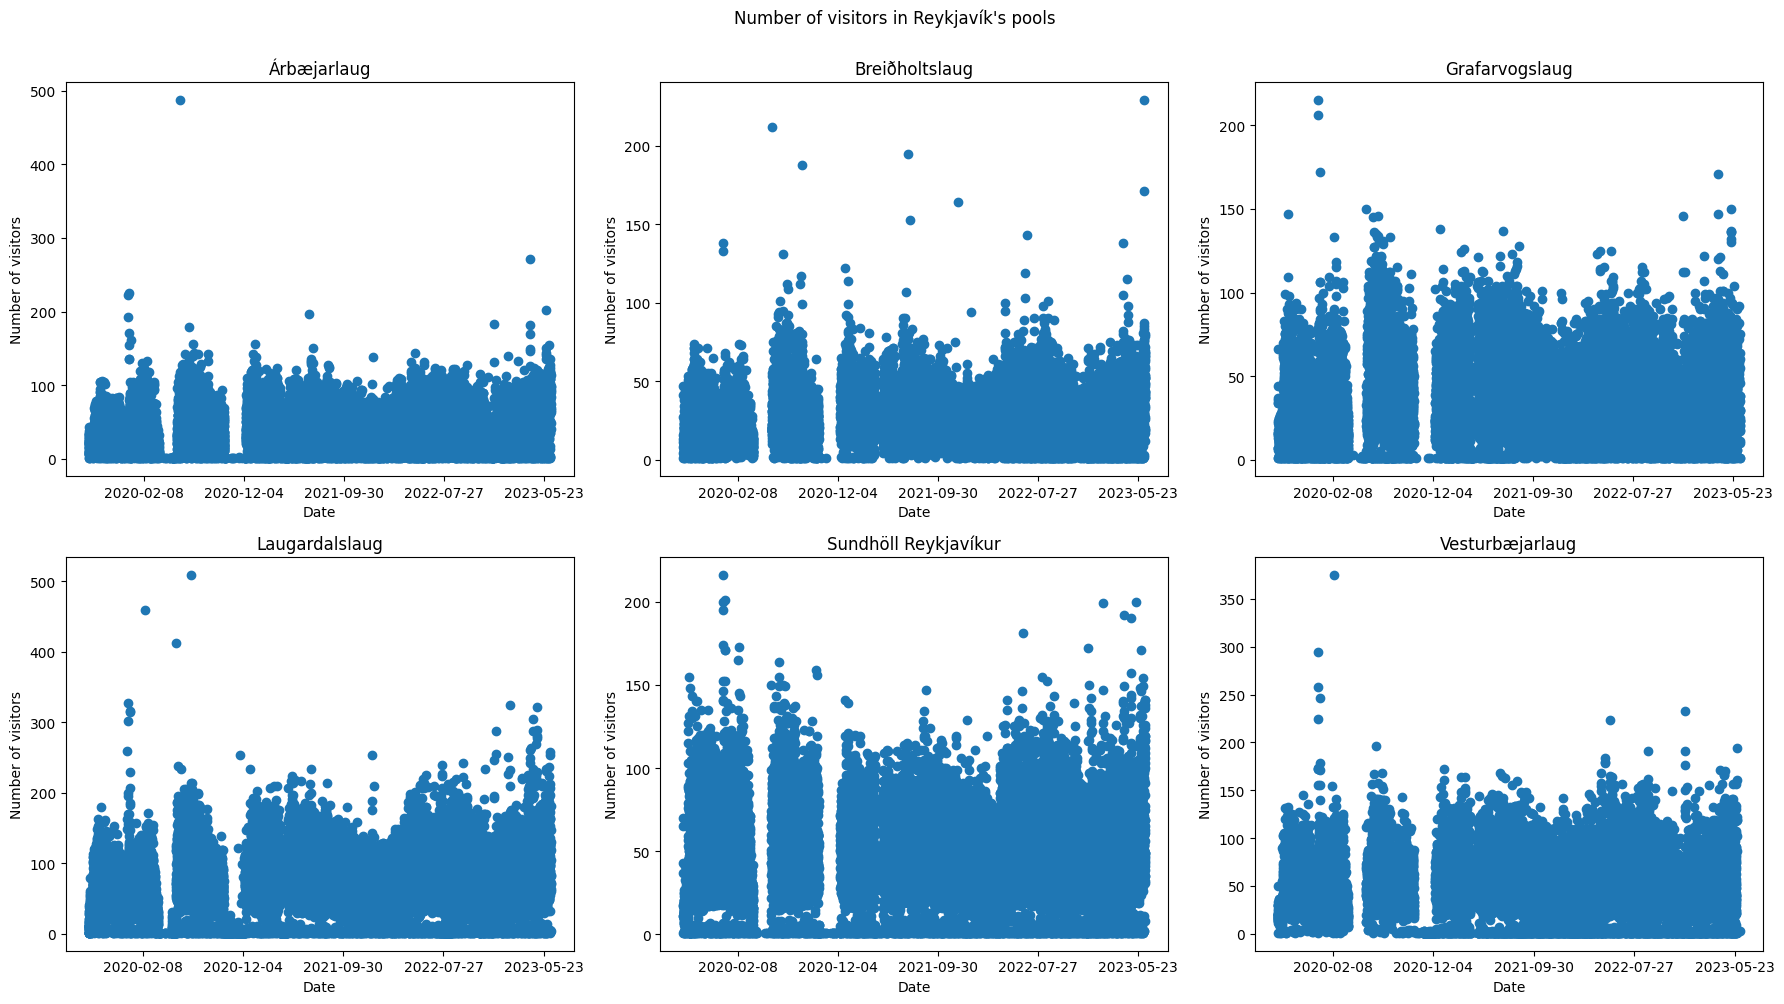

In [8]:
import matplotlib.pyplot as plt
from matplotlib.ticker import MaxNLocator

fig, axs = plt.subplots(2, 3, figsize=(18, 10))
maxn = MaxNLocator(nbins=6)

axs[0, 0].scatter(arbaejarlaug["date_time"], arbaejarlaug["visitors"])
axs[0, 0].set_xlabel("Date")
axs[0, 0].set_ylabel("Number of visitors")
axs[0, 0].set_title("Árbæjarlaug")
axs[0, 0].xaxis.set_major_locator(maxn)

axs[0, 1].scatter(breidholtslaug["date_time"], breidholtslaug["visitors"])
axs[0, 1].set_xlabel("Date")
axs[0, 1].set_ylabel("Number of visitors")
axs[0, 1].set_title("Breiðholtslaug")
axs[0, 1].xaxis.set_major_locator(maxn)

axs[0, 2].scatter(grafarvogslaug["date_time"], grafarvogslaug["visitors"])
axs[0, 2].set_xlabel("Date")
axs[0, 2].set_ylabel("Number of visitors")
axs[0, 2].set_title("Grafarvogslaug")
axs[0, 2].xaxis.set_major_locator(maxn)

axs[1, 0].scatter(laugardalslaug["date_time"], laugardalslaug["visitors"])
axs[1, 0].set_xlabel("Date")
axs[1, 0].set_ylabel("Number of visitors")
axs[1, 0].set_title("Laugardalslaug")
axs[1, 0].xaxis.set_major_locator(maxn)

axs[1, 1].scatter(sundholl_reykjavikur["date_time"], sundholl_reykjavikur["visitors"])
axs[1, 1].set_xlabel("Date")
axs[1, 1].set_ylabel("Number of visitors")
axs[1, 1].set_title("Sundhöll Reykjavíkur")
axs[1, 1].xaxis.set_major_locator(maxn)

axs[1, 2].scatter(vesturbaejarlaug["date_time"], vesturbaejarlaug["visitors"])
axs[1, 2].set_xlabel("Date")
axs[1, 2].set_ylabel("Number of visitors")
axs[1, 2].set_title("Vesturbæjarlaug")
axs[1, 2].xaxis.set_major_locator(maxn)

fig.suptitle("Number of visitors in Reykjavík's pools", y=1)

plt.tight_layout()  # Adjust the spacing between subplots
plt.show()

In [9]:
from sklearn.model_selection import train_test_split
import numpy as np

pretrain_data = pd.concat(
    [
        grafarvogslaug,
        arbaejarlaug,
        breidholtslaug,
        sundholl_reykjavikur,
        vesturbaejarlaug,
    ]
)

finetune_data = laugardalslaug.copy()

combined_data = pd.concat([pretrain_data, finetune_data], ignore_index=True)

# one-hot encoding
# one_hot = pd.get_dummies(combined_data['pool'], prefix='pool')

# X = pd.concat([one_hot, combined_data[['weekday', 'weekend', 'hour']]], axis=1)
X = combined_data[["weekday", "weekend", "hour"]]
y = np.log(combined_data["visitors"])

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

In [17]:
# from sklearn.svm import SVR
import xgboost as xgb

# pretrained_model = xgb.XGBRegressor(objective='reg:squarederror', n_estimators=2000, max_depth=3, learning_rate=0.1, random_state=42)
pretrained_model = xgb.XGBRegressor()

pretrained_model.fit(X_train, y_train)

score = pretrained_model.score(X_train, y_train)
print("Pretraining score:", score)

Pretraining score: 0.5417109476715316


In [11]:
# load the model's where we left off
finetune_model = xgb.XGBRegressor(
    objective="reg:squarederror",
    n_estimators=2000,
    max_depth=3,
    learning_rate=0.1,
    random_state=42,
)

params = pretrained_model.get_xgb_params()
finetune_model.set_params(**params)

X_finetune = finetune_data[["weekday", "weekend", "hour"]]
y_finetune = np.log(finetune_data["visitors"])

X_finetune_train, X_finetune_test, y_finetune_train, y_finetune_test = train_test_split(
    X_finetune, y_finetune, test_size=0.2, random_state=42
)

finetune_model.fit(X_train, y_train)

score = finetune_model.score(X_train, y_train)
print("Finetuning score:", score)

Finetuning score: 0.541682838094101


In [12]:
from sklearn.metrics import mean_squared_error, r2_score

y_pred = finetune_model.predict(X_test)

mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print("Mean Squared Error:", mse)
print("R-squared Score:", r2)

Mean Squared Error: 0.4476910864366218
R-squared Score: 0.5479235467278334


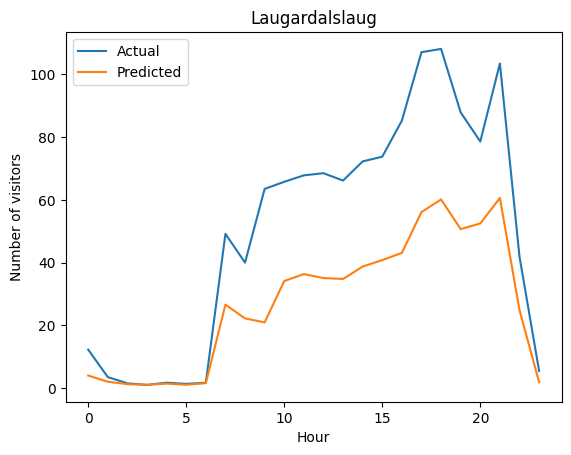

In [13]:
pred = finetune_model.predict(X_finetune_test)
actual = y_finetune_test
input = X_finetune_test

pred = np.exp(pred)
actual = np.exp(actual)

df = pd.DataFrame({"input": input["hour"], "actual": actual, "pred": pred})
df = df.sort_values(by=["input"])
df = df.reset_index(drop=True)
df = df.groupby("input").mean()
df = df.reset_index()

import matplotlib.pyplot as plt

plt.plot(df["actual"], label="Actual")
plt.plot(df["pred"], label="Predicted")
plt.xlabel("Hour")
plt.ylabel("Number of visitors")
plt.title("Laugardalslaug")
plt.legend()
plt.show()

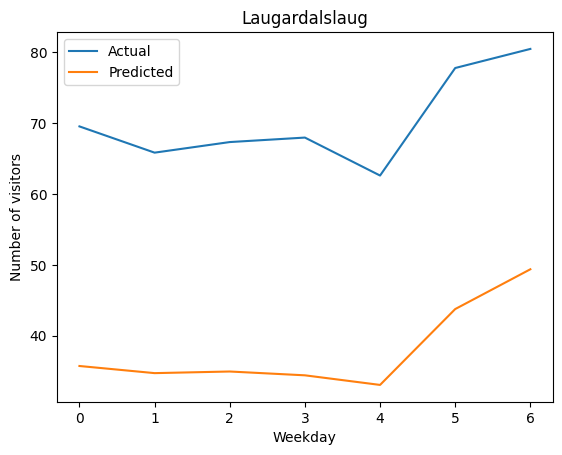

In [14]:
pred = finetune_model.predict(X_finetune_test)
actual = y_finetune_test
input = X_finetune_test

pred = np.exp(pred)
actual = np.exp(actual)

df = pd.DataFrame({"input": input["weekday"], "actual": actual, "pred": pred})
df = df.sort_values(by=["input"])
df = df.reset_index(drop=True)
df = df.groupby("input").mean()
df = df.reset_index()

import matplotlib.pyplot as plt

plt.plot(df["actual"], label="Actual")
plt.plot(df["pred"], label="Predicted")
plt.xlabel("Weekday")
plt.ylabel("Number of visitors")
plt.title("Laugardalslaug")
plt.legend()
plt.show()

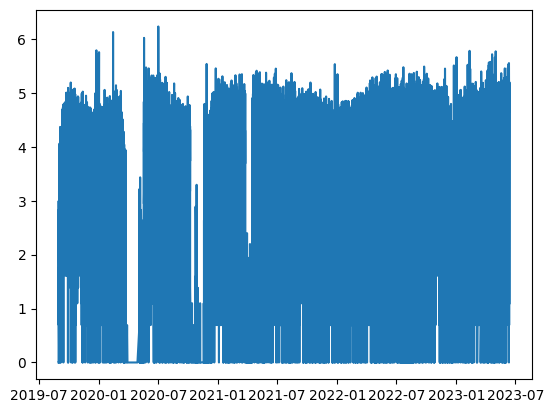

In [15]:
from matplotlib import pyplot as plt
import numpy as np

date = laugardalslaug["date_time"]
visitors = laugardalslaug["visitors"]

visitors = np.log(visitors)

plt.plot(date, visitors)

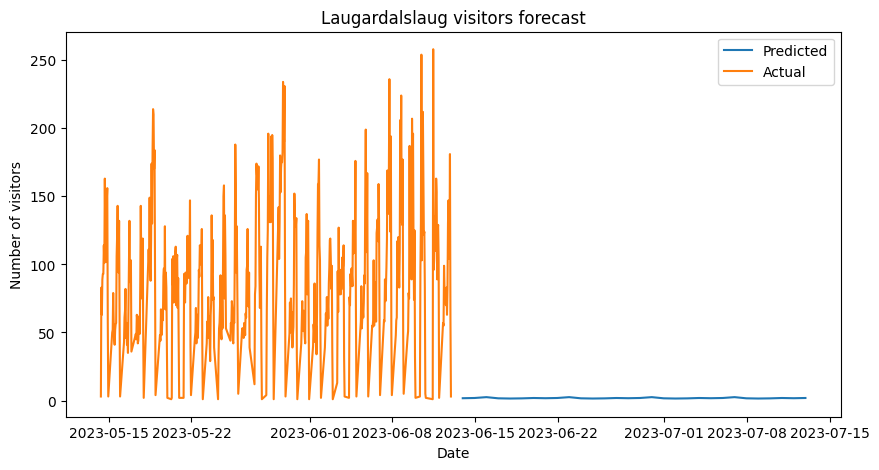

In [16]:
# forecast next 30 days
import datetime
import numpy as np

# get last date
last_date = laugardalslaug["date_time"].iloc[-1]

# create next 30 days
next_30_days = []
for i in range(1, 31):
    next_30_days.append(last_date + datetime.timedelta(days=i))

# create dataframe
next_30_days = pd.DataFrame(next_30_days, columns=["date_time"])

# add weekday, weekend and hour
next_30_days["weekday"] = next_30_days["date_time"].dt.weekday
next_30_days["weekend"] = next_30_days["weekday"].apply(lambda x: 1 if x > 4 else 0)
next_30_days["hour"] = next_30_days["date_time"].dt.hour

# make predictions
next_30_days["visitors"] = finetune_model.predict(
    next_30_days[["weekday", "weekend", "hour"]]
)
next_30_days["visitors"] = np.exp(
    next_30_days["visitors"]
)  # convert back to original scale
# next_30_days['visitors'] = next_30_days['visitors'].apply(lambda x: 0 if x < 0 else x)
# next_30_days['visitors'] = next_30_days['visitors'].apply(lambda x: np.round(x))

# Get the actual visitors data for the previous 30 days
actual_data = laugardalslaug[
    laugardalslaug["date_time"] >= (last_date - datetime.timedelta(days=30))
]

# Plot predictions and actual data
plt.figure(figsize=(10, 5))
plt.plot(next_30_days["date_time"], next_30_days["visitors"], label="Predicted")
plt.plot(actual_data["date_time"], actual_data["visitors"], label="Actual")
plt.title("Laugardalslaug visitors forecast")
plt.xlabel("Date")
plt.ylabel("Number of visitors")
plt.legend()
plt.show()